# Improvements to models

We attempt to modify the model in the following ways:  

1.  Generalizing to a second order model  (first order for leaders/predators and second order for followers/prey)  

2. Adding perception cones of individuals 

3. Change the area of effect of other individuals: the interaction force is no longer averaged over the entire population but over $k$ nearest neighbours

## 1 A second order model  

The following is a second order model (first order for the predator)

$$
\begin{equation}
    \begin{cases}
        \dot{x}_j = v_j\\[2ex]
        \dot{v}_j = \dfrac1N \sum\limits_{k=1}^N  \bigg\{\dfrac{\kappa_h(v_k-v_j)}{(\zeta_h ^2 + \|x_j-x_k\|^2)^{\gamma_h}} - a(x_j-x_k) + b_1\dfrac{x_j-x_k}{\|x_j-x_k\|^2}\bigg\} + {\color{red}b_2\dfrac{x_j-z}{\|x_j-z\|^2}} \\[5ex]
        \dot{z} = \dfrac{1}{N} \sum\limits_{k=1}^N  c\dfrac{x_k-z}{\|x_k-z\|^p}
    \end{cases}
\end{equation}
$$  

For the moment $\zeta=\gamma=1$ for both the prey and predator, while the parameters $a,b_1, b_2, c, p$ can be tuned.  
It might be better if the summation above was taken to exclude the $j^{th}$ prey.  

An observation is that larger $p$ will lead to predators moving away (inversely proportional to distance)

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from solvers.rk_solvers import *
from models import *
from solvers.euler import *
from helper import *

### Case 1

A stable state $\kappa_h = 0.5, a=1, b_1 = 1, b_2 = 0.07, c = 10 ,p = 1.2$  

In [2]:
N = 10

case1  = computeSoln(model1, 
    {'no. of prey': N, 
    'kappa for prey': 0.5, 
    'attraction of prey a': 1, 
    'repulsion of prey b_1': 1, 
    'repulsion of pred b_2': 0.07, 
    'attraction of pred c': 10, 
    'exponent of dist pred p': 1.2},
    1000,
    (0,20),
    False,
    'random',
    'rk2',
    False,
    [i*2  for i in range(10)]
    )

No. of time steps: 1000


100%|██████████| 999/999 [00:00<00:00, 1508.27it/s]


c:\Users\yunjie wang\anaconda3\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
c:\Users\yunjie wang\anaconda3\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


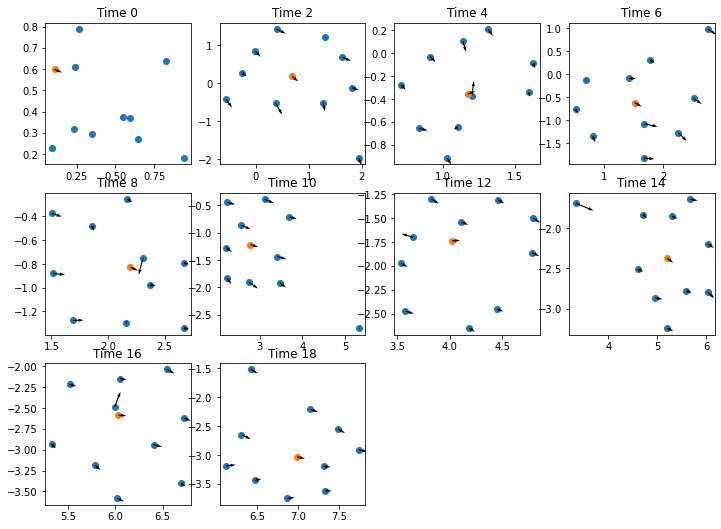

In [3]:
multiPlot(case1, axis_lim = None, second_order = True, quiver=True)

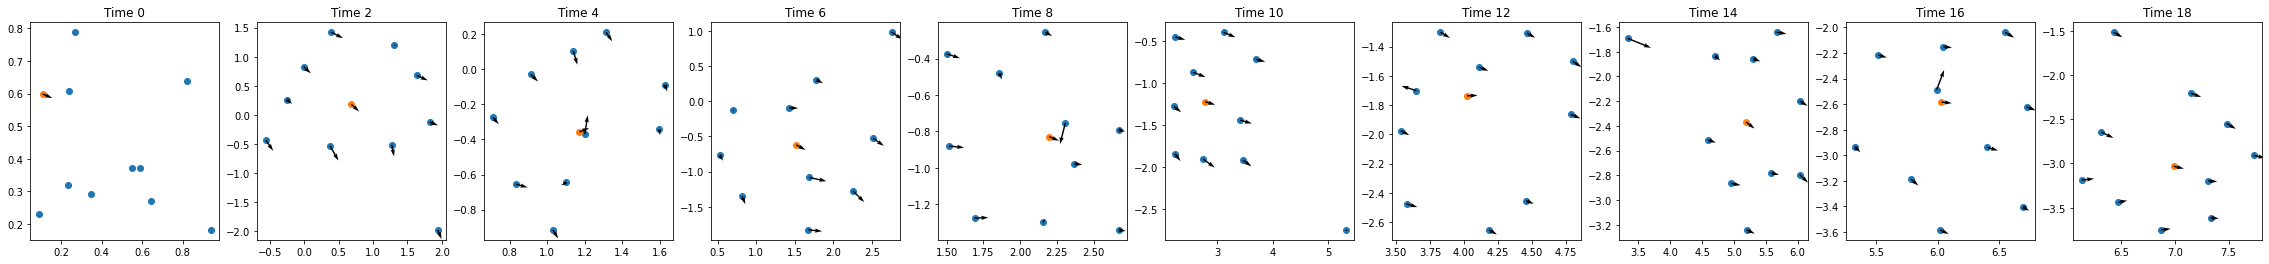

In [4]:
exportPlot(case1, axis_lim = None, second_order = True, quiver=True, export_dir='plots')

### Case 2

A  state where the predator drives the prey into a cluster $\kappa_h = 0.5, a=1, b_1 = 1, b_2 = 0.07, c = 1.5 ,p = 1.2$  

In [6]:
N = 100

case2  = computeSoln(model1, 
    {'no. of prey': N, 
    'kappa for prey': 0.5, 
    'attraction of prey a': 1, 
    'repulsion of prey b_1': 1, 
    'repulsion of pred b_2': 0.07, 
    'attraction of pred c': 1.5, 
    'exponent of dist pred p': 1.2},
    1000,
    (0,100),
    False,
    'random',
    'rk2',
    False,
    [i*10  for i in range(10)],
    12)

No. of time steps: 1000


100%|██████████| 999/999 [00:05<00:00, 179.81it/s]


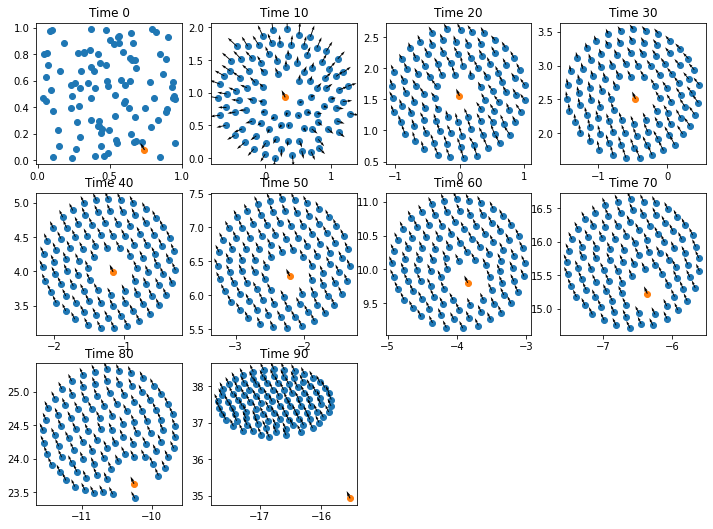

In [7]:
multiPlot(case2, axis_lim = None, second_order = True, quiver=True)

### Case 3

A state where the predator is more active and prey experiencing greater repulsion with  $\kappa_h = 0.5, a=0, b_1 = 0.15, b_2 = 0.15, c = 10 ,p = 3$

In [8]:
N = 100

case3  = computeSoln(model1, 
    {'no. of prey': N, 
    'kappa for prey': 0.5, 
    'attraction of prey a': 0, 
    'repulsion of prey b_1': 0.15, 
    'repulsion of pred b_2': 0.15, 
    'attraction of pred c': 10, 
    'exponent of dist pred p': 3},
    1000,
    (0,200),
    False,
    'random',
    'rk2',
    False,
    [i*10  for i in range(10)],
    12)

No. of time steps: 1000


100%|██████████| 999/999 [00:06<00:00, 152.48it/s]


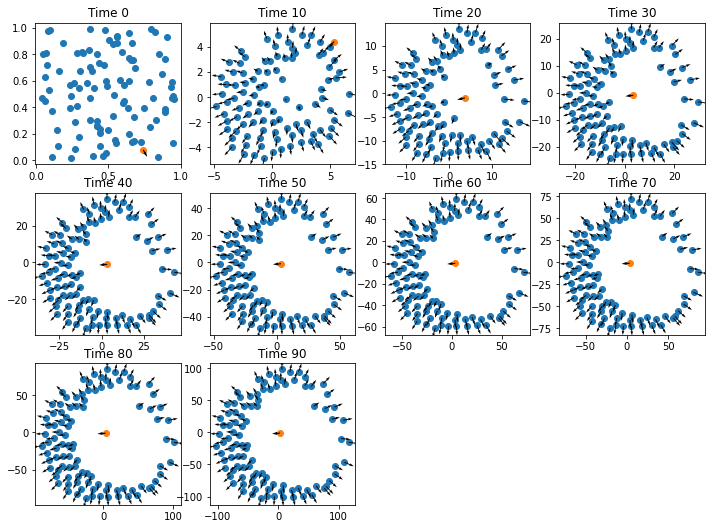

In [9]:
multiPlot(case3, axis_lim = None, second_order = True, quiver=True)

## 2 Adding the perception cones  

This is the same model but each individual of the prey can only react to the changes within their perceptioin cones.  

$$
\begin{equation*}
    \begin{cases}
        \dot{x}_j = v_j\\[2ex]
        \dot{v}_j = \dfrac1N \sum\limits_{k=1}^N  \psi_\alpha(x_k,x_j,v_k) \bigg\{\dfrac{\kappa_h(v_k-v_j)}{(\zeta_h ^2 + \|x_j-x_k\|^2)^{\gamma_h}} - a(x_j-x_k) + b_1\dfrac{x_j-x_k}{\|x_j-x_k\|^2}\bigg\} + {\color{red}b_2\dfrac{x_j-z}{\|x_j-z\|^2} \psi_\alpha(x_j,z,v_j)} \\[5ex]  
        \dot{z} = \dfrac{1}{N} \sum\limits_{k=1}^N  \bigg\{c\dfrac{x_k-z}{\|x_k-z\|^p} \bigg\} \psi_\alpha(z,x_k,\dot{z})
    \end{cases}
\end{equation*}
$$  

where the perception cone for the $i^{th}$ prey is given by  

$$
\begin{equation*}
        \Sigma(x_i, v_i, \theta) = \left\{ y \in \mathbb{R^d}: \frac{(x_i-y) \cdot v_i}{|x_i-y||v_i|} \geq \cos(\theta/2) \right\}
\end{equation*}  
$$  
The perception is computed by  
$$
\begin{equation*}
        \psi_{\alpha} (x_i, x_j, v_i) = p_2 + (p_1-p_2) \mathbf{1}_{\Sigma(x_i, v_i, \theta)}
\end{equation*} 
$$
and $\alpha = (\theta, p_1, p_2)$ is the parameter vector with $p_1,p_2 \in [0,1]$

$\kappa_h = 0.5, a=0, b_1 = 0.15, b_2 = 0.55, p_1 = 0.8, p_2 = 0.4, \theta_{prey} = \frac{\pi}{3}, 
\theta_{pred} = \frac{2\pi}{5}, c = 10 ,p = 3$  

In [11]:
N = 100

case4  = computeSoln(func=model3, 
    params={'no. of prey': N, 
    'kappa for prey': 0.5, 
    'attraction of prey a': 0, 
    'repulsion of prey b_1': 0.15, 
    'repulsion of pred b_2': 0.55,
    'p1 spotted': 0.8,
    'p2 not spotted':0.4,
    'angle_prey': np.cos(np.pi / 3),
    'angle_pred': np.cos(np.pi / 2.5), 
    'attraction of pred c': 10, 
    'exponent of dist pred p': 3},
    steps=1000,
    times=(0,100),
    second_order=False,
    init_sty='random',
    method='rk4',
    return_vel=True,
    sample_points=[i*10  for i in range(10)],
    size=15)

No. of time steps: 1000


  0%|          | 0/999 [00:00<?, ?it/s]/home/isomorphicdude/newproject/Summer2022UROP/models.py:169: RuntimeWarning: invalid value encountered in divide
  mask_hh = (dot_prod_h / abs_val_h)>=a_h # (N,N-1,1)
/home/isomorphicdude/newproject/Summer2022UROP/models.py:185: RuntimeWarning: invalid value encountered in divide
  mask_hp = (np.sum(vprey*(pprey-ppred), axis = 1)[:,np.newaxis] / (norm_pred * np.linalg.norm(vprey)))>=a_h
100%|██████████| 999/999 [00:15<00:00, 62.67it/s]


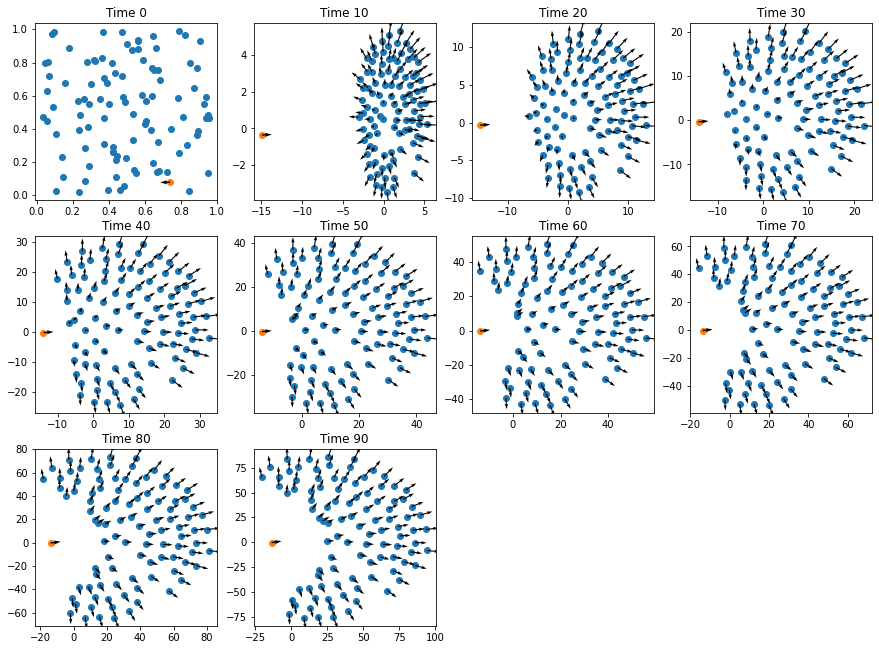

In [12]:
multiPlot(case4, axis_lim = None, second_order = True, quiver=True)

## 3 Adding topological effect  

Finally we consider the nearest neighbours' effect on each prey.   

Note that the perception cone model does not necessarily reflect reality, as animals have senses other than vision.  We attempt to resolve this issue by taking the *union* of the nearest neighbours and the perception cone.

$$
\begin{equation*}
    \begin{cases}
        \dot{x}_j = v_j\\[2ex]
        \dot{v}_j = \dfrac1N \sum\limits_{k=1}^N  \varphi_\alpha(x_k,x_j,v_k) \bigg\{\dfrac{\kappa_h(v_k-v_j)}{(\zeta_h ^2 + \|x_j-x_k\|^2)^{\gamma_h}} - a(x_j-x_k) + b_1\dfrac{x_j-x_k}{\|x_j-x_k\|^2}\bigg\} + {\color{red}b_2\dfrac{x_j-z}{\|x_j-z\|^2} \varphi_\alpha(x_j,z,v_j)} \\[5ex]  
        \dot{z} = \dfrac{1}{N} \sum\limits_{k=1}^N  \bigg\{c\dfrac{x_k-z}{\|x_k-z\|^p} \bigg\} \varphi_\alpha(z,x_k,\dot{z})
    \end{cases}
\end{equation*}
$$  

where the modified perception cone for the $i^{th}$ prey is given by  

$$
\begin{equation*}
        \Lambda(x_i, v_i, \mathcal{N}, \theta) = \left\{ y \in \mathbb{R^d}: \frac{(x_i-y) \cdot v_i}{|x_i-y||v_i|} \geq \cos(\theta/2) \right\} \cup B_{\mathcal{N}}(x_i; \mathbf{x}, z)
\end{equation*}  
$$  

Here $B_{\mathcal{N}}(x_i; \mathbf{x}, z)$ denotes the ball containing $\mathcal{N}$ nearest neighbours (both prey and predator) of the $i^{th}$ prey. Similar equation holds for the predator.   

The perception is computed by  
$$
\begin{equation*}
        \varphi_{\alpha} (x_i, x_j, v_i) = p_2 + (p_1-p_2) \mathbf{1}_{\Lambda_(x_i, v_i, \mathcal{N}, \theta)}
\end{equation*} 
$$
and $\alpha = (\theta, \mathcal{N}, p_1, p_2)$ is the parameter vector with $p_1,p_2 \in [0,1]$

Some implementation ideas:  
1.    Keep track of the $\mathcal{N}$ nearest neighbours using an adjacency list (Linear time)  
2.    Use built-in methods provided by libraries like `scikit-learn`.    


The nearest neighbours can be returned as an array of indices, at which the elements of original perception cone masks are set to $1$.

$\kappa_h = 0.5, a=0, b_1 = 0.15, b_2 = 0.55, p_1 = 0.8, p_2 = 0.4, \theta_{prey} = \frac{\pi}{3}, 
\theta_{pred} = \frac{2\pi}{5}, \mathcal{N} = 5, c = 10 ,p = 3$  

In [14]:
N = 100

case5  = computeSoln(func=model4, 
    params={'no. of prey': N, 
    'kappa for prey': 0.5, 
    'attraction of prey a': 0, 
    'repulsion of prey b_1': 0.15, 
    'repulsion of pred b_2': 0.55,
    'p1 spotted': 0.8,
    'p2 not spotted':0.4,
    'angle_prey': np.cos(np.pi / 3),
    'angle_pred': np.cos(np.pi / 2.5), 
    'num_neighbours': 5,
    'attraction of pred c': 10, 
    'exponent of dist pred p': 3},
    steps=1000,
    times=(0,100),
    second_order=False,
    init_sty='random',
    method='rk4',
    return_vel=True,
    sample_points=[i*10  for i in range(10)],
    size=15)

No. of time steps: 1000


  0%|          | 0/999 [00:00<?, ?it/s]/tmp/ipykernel_2174/1753853040.py:39: RuntimeWarning: invalid value encountered in divide
  mask_hh = (dot_prod_h / abs_val_h)>=a_h # (N,N-1,1)
/tmp/ipykernel_2174/1753853040.py:55: RuntimeWarning: invalid value encountered in divide
  mask_hp = (np.sum(vprey*(pprey-ppred), axis = 1)[:,np.newaxis] / (norm_pred * np.linalg.norm(vprey)))>=a_h
100%|██████████| 999/999 [00:16<00:00, 61.24it/s]


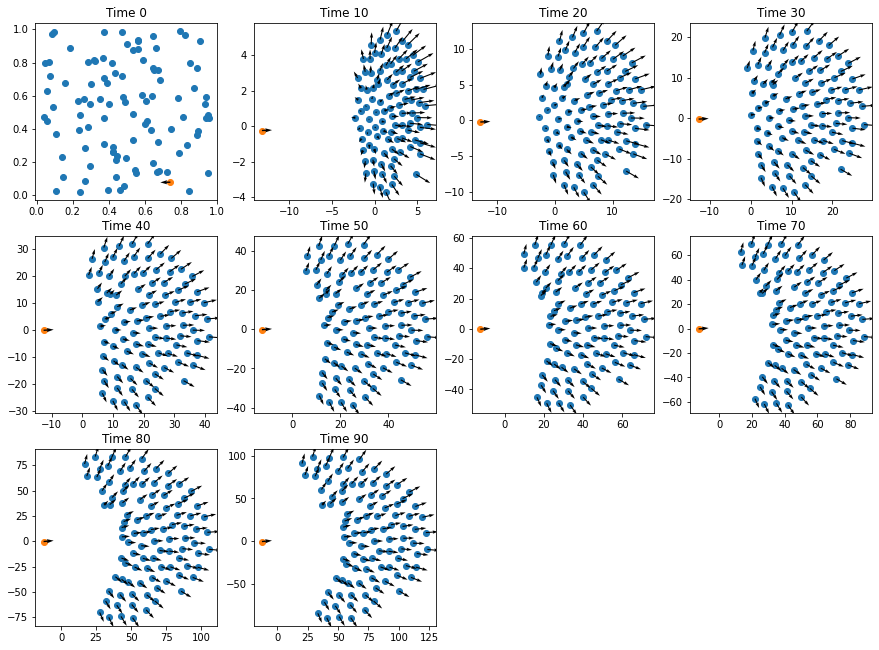

In [15]:
multiPlot(case5, axis_lim = None, second_order = True, quiver=True)